<a href="https://colab.research.google.com/github/Bhashitha-07/23RH1A05Z4/blob/main/smart_waste_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python tensorflow fastapi uvicorn streamlit kaggle matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 10.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip garbage-classification.zip -d garbage_data

Streaming output truncated to the last 5000 lines.
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: garbage_data/Garbage classif

In [ ]:
import os
base_dir = "garbage_data/Garbage classification/Garbage classification"
print("Classes available:", os.listdir(base_dir))

Classes available: ['plastic', 'trash', 'cardboard', 'metal', 'paper', 'glass']


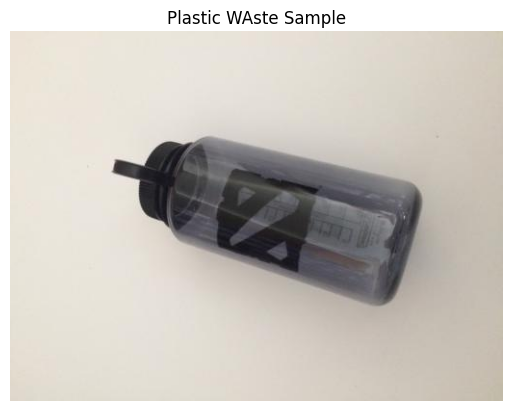

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

image_path = f'{base_dir}/plastic/plastic1.jpg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Plastic WAste Sample")
plt.axis('off')
plt.show()

*****DATA PREPROCESSING & UNDERSTANDING*****

GOAL
1. Understand data structure
2. Preprocessing
    * Resize
    * Normalize
    * Augment
    

In [ ]:
import os
#base_dir = "garbage_data/Garbage classification/Garbage classification"
classes = os.listdir(base_dir)

for cls in classes:
  path = os.path.join(base_dir, cls)
  count = len(os.listdir(path))
  print(f"{cls}: {count} images")

plastic: 482 images
trash: 137 images
cardboard: 403 images
metal: 410 images
paper: 594 images
glass: 501 images


In [ ]:
#Resize
import tensorflow as tf

IMG_SIZE = 128
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Normalizing
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# Augment
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
# step 1 we build a cnn model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


IMG_SIZE = 128
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 classes
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Get the labels from train_ds
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights_dict
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.4560 - loss: 1.4479 - val_accuracy: 0.7426 - val_loss: 0.6939
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7785 - loss: 0.6248 - val_accuracy: 0.7822 - val_loss: 0.6109
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8489 - loss: 0.4270 - val_accuracy: 0.7881 - val_loss: 0.5951
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8715 - loss: 0.3244 - val_accuracy: 0.7881 - val_loss: 0.6036
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9220 - loss: 0.2304 - val_accuracy: 0.8238 - val_loss: 0.5716
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9453 - loss: 0.1726 - val_accuracy: 0.8079 - val_loss: 0.6225
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9646 - loss: 0.1235 - val_accuracy: 0.8158 - val_loss: 0.6214
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9706 - loss: 0.1200 - val_accuracy: 0.8099 -

In [ ]:
model.save("waste_mgmt.keras", save_format="keras")  # safer than HDF5 (.h5)


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("waste_mgmt.keras")

Saving plastic1.jpg to plastic1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


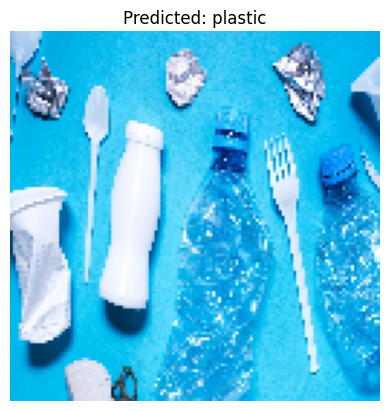

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

#Load Model
model = tf.keras.models.load_model("waste_mgmt.keras")

#Class labels
class_names = ['cardboard','glass','metal','paper','plastic','trash']

#Upload image manually (colab)
from google.colab import files
uploaded = files.upload()

#Preprocess input for MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

for file_name in uploaded.keys():
  img_path = file_name

  #load and resize image 224x224

  img = image.load_img(img_path, target_size=(128, 128))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_arary = preprocess_input(img_array)

  #Predict
  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction)]

  #Display the image with prediction
  plt.imshow(img)
  plt.title(f"Predicted: {predicted_class}")
  plt.axis('off')
  plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import gradio as gr
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load model
model = tf.keras.models.load_model("waste_mgmt.h5")

# Class labels
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Prediction function
def predict_waste(img):
    # Resize to model input size
    img = img.resize((128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    return f"♻️ Predicted: {predicted_class} ({confidence * 100:.2f}% confidence)"

# Gradio UI
interface = gr.Interface(
    fn=predict_waste,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Waste Material Classifier",
    description="Upload a waste item image and let the model classify it (e.g., cardboard, glass, metal, paper, plastic, trash)."
)

# Launch the app
interface.launch()